In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from scipy.ndimage import sobel

### Load the image and view the whole thing

In [2]:
IMAGE_FILE = '/home/spotter/data/dic/high_constrast/HC Reference.tif'

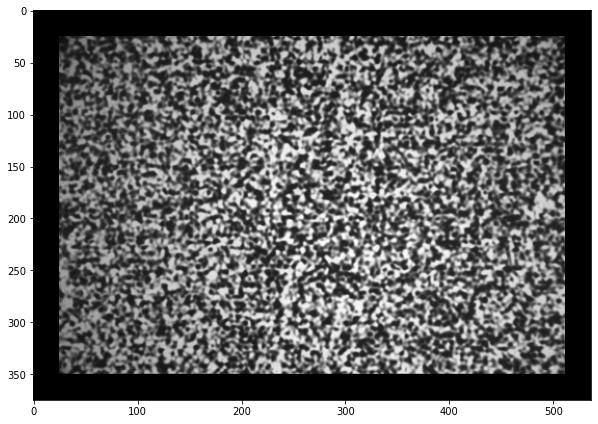

In [3]:
def_image = np.array(Image.open(IMAGE_FILE))
# Pad the image a bit so we can artificially deform it
def_image = np.pad(def_image, ((25, 25), (25, 25)))
fig = plt.figure(figsize=(10, 20))
plt.imshow(def_image, cmap='gray')
plt.show()

### Define image interpolation junk

In [4]:
# Why?? Maybe just use scipy.interpolate instead??

from scipy.interpolate import RectBivariateSpline

class ImageInterpolator:
    def __init__(self, image):
        self.image = image
        self.dx = None
        self.dy = None
        self.dxy = None
        self._coefficient_cache = {}
        
    def interpolate(self, row, column):
        # FIXME -- need better names
        xmin = int(np.floor(column))
        x = column - xmin
        ymin = int(np.floor(row))
        y = row - ymin
        
        if None in (self.dx, self.dy, self.dxy):
            self._compute_sobel()
            
        key = f'row{ymin}col{xmin}'
        
        coeffs = self._coefficient_cache.get(key, None)
        
        if coeffs is None:
            coeffs = self._compute_bicubic_coeffs(xmin, ymin)
            self._coefficient_cache[key] = coeffs
        
        xs = np.array([1, x, x**2, x**3])
        ys = np.array([1, y, y**2, y**3])
        
        return xs.dot(coeffs.dot(ys))
        
            
    def _compute_bicubic_coeffs(self, col, row):
        """
        (0, 1) x ------ x (1, 1)
               |        |
               |        |
               |        |
        (0, 0) x ------ x (1, 0)
        """
        # FIXME - Cache these in class instantiation
        
        C = np.array([[1, 0, 0, 0],
                      [0, 0, 1, 0],
                      [-3, 3, -2, -1],
                      [2, -2, 1, 1]], dtype=float)
    
        D = np.array([[1., 0., -3., 2.],
                      [0., 0., 3., -2.],
                      [0., 1., -2., 1.],
                      [0., 0., -1., 1.]])
        
        col_slice = slice(col, col + 2, 1)
        row_slice = slice(row, row + 2, 1)
        
        F = np.zeros((4, 4))
        # Deal with image axis
        # FIXME -- need to deal with images being floats
        F[:2, :2] = np.flipud(self.image[row_slice, col_slice])
        F[2:, :2] = np.flipud(self.dy[row_slice, col_slice])
        F[:2, 2:] = np.flipud(self.dx[row_slice, col_slice])
        F[2:, 2:] = np.flipud(self.dxy[row_slice, col_slice])
        
        coeffs = C @ F @ D
        
        return coeffs        
            
    def _compute_sobel(self):
        self.dx = sobel(self.image, axis=0, mode='constant')
        self.dy = sobel(self.image, axis=1, mode='constant')
        self.dxy = sobel(self.dy, axis=0, mode='constant')
        
        
class ImageInterpolator:
    def __init__(self, image):
        # XXX: Flipping this correctly?
        xs = np.arange(image.shape[1])
        ys = np.arange(image.shape[0])
        self.spline = RectBivariateSpline(ys, xs, image)
        
    def interpolate(self, x, y):
        return self.spline(x, y, grid=False)
        

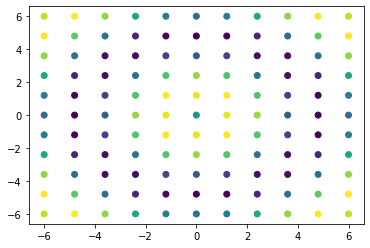

In [5]:
# Do a synthetic test
def f(x, y):
    return np.sin(np.sqrt(x ** 2 + y ** 2))

x = np.linspace(-6, 6, 11)
y = np.linspace(-6, 6, 11)

xs, ys = np.meshgrid(x, y)
ys = np.flipud(ys)  # Y positive down

z = f(xs, ys)

plt.scatter(xs, ys, c=z);

In [6]:
interpolator = ImageInterpolator(z)

def find_x(col):
    idx = int(np.floor(col))
    return xs[0, idx] + (col - idx) * (xs[0, idx + 1] - xs[0, idx])

def find_y(row):
    idx = int(np.floor(row))
    return ys[idx, 0] - (row - idx) * (ys[idx, 0] - ys[idx + 1, 0])

row, col = 1., 1.
x, y = find_x(col), find_y(row)
interpolated = interpolator.interpolate(row, col)

print(f'x: {x}')
print(f'y: {y}')
print(f'z: {f(x, y)}')
print(f'interpolated: {interpolated}')

x: -4.8
y: 4.799999999999999
z: 0.4838422650684992
interpolated: 0.48384226506849953


### Now make a synthetic reference image

In [7]:
rows = np.arange(def_image.shape[0])
columns = np.arange(def_image.shape[1])

xs, ys = np.meshgrid(columns, rows)

forward_grad = np.array([[1.05, 0], [0, 1.0]])
inv_grad = np.linalg.inv(forward_grad)

new_points = forward_grad @ np.column_stack([xs.ravel(), ys.ravel()]).T

"""
#FIXME: Ignore for now
interpolator = ImageInterpolator(def_image)
new_ys, new_xs = new_points[0], new_points[1]
ref_data = interpolator.interpolate(new_xs, new_ys)
"""
warp = np.column_stack([inv_grad, np.array([[0], [0]])])
# FIXME: Package dependency on openCV is no good. Okay (proabably) for example, but considter rolling to skimage
ref_image = cv2.warpAffine(def_image, warp, def_image.T.shape, flags=cv2.INTER_CUBIC)

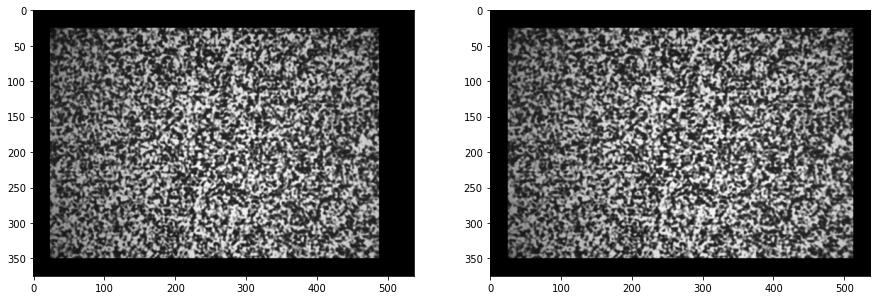

In [8]:
fig, ((ax0, ax1)) = plt.subplots(1, 2, figsize=(15, 10))
ax0.imshow(ref_image, cmap='gray')
ax1.imshow(def_image, cmap='gray')

### Now basic functions for spline stuff

### The surface itself

In [77]:
class BSplineSurface:
    """ A B-Spline Surface
        
        Attributes
        ----------
        degree_u: int
            The degree of the surface in u direction
        degree_v : int
            The degree of the surface in the v direction
        control_points : array
            The control points of the surface
        knot_vector_u : array
            The knot vector of the surface in u direction
        knot_vector_v : array
            The knot voector of the surface in v direction
    """

    def __init__(self, **kwargs):
        self._degree_u = None if 'degree_u' not in kwargs.keys() else kwargs['degree_u']
        self._degree_v = None if 'degree_v' not in kwargs.keys() else kwargs['degree_v']
        self._num_control_points_u = None
        self._num_control_points_v = None
        self._control_points = None
        self._knot_vector_u = None
        self._knot_vector_v = None
        # FIXME: Not relevant for 2D only
        self.dimension = 2

    @property
    def degree_u(self):
        return self._degree_u

    @degree_u.setter
    def degree_u(self, degree):
        if degree < 1:
            raise ValueError('Degree must be greater than zero')
        self._degree_u = degree

    @property
    def degree_v(self):
        return self._degree_v

    @degree_v.setter
    def degree_v(self, degree):
        if degree < 1:
            raise ValueError('Degree mvst be greater than zero')
        self._degree_v = degree

    @property
    def num_ctrlpts_u(self):
        return self._num_control_points_u

    @num_ctrlpts_u.setter
    def num_ctrlpts_u(self, num):
        if num < self.degree_u + 1:
            msg = ('Number of control points in u must be {} '
                   'for a surface with u degree of {}').format(self.degree_u + 1, self.degree_u)
            raise ValueError(msg)

        self._num_control_points_u = num

    @property
    def num_ctrlpts_v(self):
        return self._num_control_points_v

    @num_ctrlpts_v.setter
    def num_ctrlpts_v(self, num):
        if num < self.degree_v + 1:
            msg = ('Number of control points in v must be {} '
                   'for a surface with v degree of {}').format(self.degree_v + 1, self.degree_v)
            raise ValueError(msg)

        self._num_control_points_v = num

    @property
    def control_points(self):
        return self._control_points

    @control_points.setter
    def control_points(self, ctrlpt_array):
        if self._degree_u is None:
            raise ValueError('Surface degree u must be set before setting control points')

        if self._degree_v is None:
            raise ValueError('Surface degree v must be set before setting control points')

        if not ctrlpt_array.shape[-1] != self.dimension:
            raise ValueError('Control point points must be in either R{}'.format(self.dimension))

        self._control_points = ctrlpt_array

    @property
    def knot_vector_u(self):
        return self._knot_vector_u

    @knot_vector_u.setter
    def knot_vector_u(self, kv):
        if self._degree_u is None:
            raise ValueError('Surface degree in u direction must be set before setting knot vector')

        if self._control_points is None:
            raise ValueError("Surface control points must be set before setting knot vector")

        if self._num_control_points_u is None:
            raise ValueError('Surface control point number in u must be set before setting knot vector')
        
        if self._check_knot_vector(kv, direction='u'):
            self._knot_vector_u = kv 

    @property
    def knot_vector_v(self):
        return self._knot_vector_v

    @knot_vector_v.setter
    def knot_vector_v(self, kv):
        if self._degree_v is None:
            raise ValueError('Surface degree in v direction must be set before setting knot vector')

        if self._control_points is None:
            raise ValueError("Surface control points must be set before setting knot vector")

        if self._num_control_points_v is None:
            raise ValueError('Surface control point number in v must be set before setting knot vector')
        
        if self._check_knot_vector(kv, direction='v'):
            self._knot_vector_v = kv
            
    def single_point(self, u, v):
        """ Evaluate a surface at a single parametric point

        Parameters
        ----------
        knot_u : float
            Parameter in u at which to evaluate surface 
        knot_v : float
            Parameter in v at withch to evaluate surface

        Returns
        -------
        point : array
            Evalued coordinate point 
        """
        u = float(u)
        v = float(v)

        if not validate_knot(u):
            raise ValueError('u parameter must be in interval [0, 1]')
        if not validate_knot(v):
            raise ValueError('v parameter must be in interval [0, 1]')

        u_span = find_span(self._num_ctrlpts_u, self._degree_u, u, self._knot_vector_u)
        v_span = find_span(self._num_ctrlpts_v, self._degree_v, v, self._knot_vector_v)
        basis_funs_u = basis_functions(u_span, u, self._degree_u, self._knot_vector_u)
        basis_funs_v = basis_functions(v_span, v, self._degree_v, self._knot_vector_v)
        ctrlpt_x = self._control_points[:, 0]
        ctrlpt_y = self._control_points[:, 1]
        ctrlpt_z = self._control_points[:, 2]

        x_array = np.reshape(ctrlpt_x, (self._num_ctrlpts_u, self._num_ctrlpts_v))
        y_array = np.reshape(ctrlpt_y, (self._num_ctrlpts_u, self._num_ctrlpts_v))
        z_array = np.reshape(ctrlpt_z, (self._num_ctrlpts_u, self._num_ctrlpts_v))

        x = basis_funs_u @ x_array[u_span - self._degree_u:u_span + 1, v_span - self._degree_v:v_span + 1] \
            @ basis_funs_v
        y = basis_funs_u @ y_array[u_span - self._degree_u:u_span + 1, v_span - self._degree_v:v_span + 1] \
            @ basis_funs_v
        z = basis_funs_u @ z_array[u_span - self._degree_u:u_span + 1, v_span - self._degree_v:v_span + 1] \
            @ basis_funs_v

        point = np.array([x, y, z])

        return point

    def points(self, knot_array):
        """ Evaluate the surface at multiple parametric locations

        Parameters
        ----------
        knots : array
            Array of parametric points (u,v) to evaluate
        
        Returns
        -------
        points : array
            Evaluated coordinat points
        """
        knot_array = np.asarray(knot_array, dtype=np.double)
        if knot_array.ndim != 2.0:
            raise ValueError('Parameter array must be 2D')

        values = [self.single_point(parameter[0], parameter[1]) for parameter in knot_array]

        return np.array(values)

    def derivatives(self, u, v, order_u, order_v, normalize=True):
        """ Evaluate the derivatives of the surface at specified knot up to
        min (order, degree)

        Parameters
        ----------
        knot_u : float
            Parametric in u point to evaluate
        knot_v : float
            Parametric in u point to evaluate
        order_u : int
            Max order of derivatives in u to evaluate
        order_v : int
            Max order of derivatives in v to evaluate
        normalize : bool, optional
            Normalize output derivatives
        
        Returns
        -------
        derivs : array
            Array of points and derivatives at specified knot
        """
        u = float(u)
        v = float(v)

        if not validate_knot(u):
            raise ValueError('u parameter must be in interval [0, 1]')
        if not validate_knot(v):
            raise ValueError('v parameter must be in interval [0, 1]')

        max_order_u = min(order_u, self._degree_u)
        max_order_v = min(order_v, self._degree_v)

        u_span = find_span(self._num_control_points_u, self._degree_u, u, self._knot_vector_u)
        v_span = find_span(self._num_control_points_v, self._degree_v, v, self._knot_vector_v)

        basis_funs_u_ders = basis_function_ders(u_span, u, self._degree_u, self._knot_vector_u, max_order_u)
        basis_funs_v_ders = basis_function_ders(v_span, v, self._degree_v, self._knot_vector_v, max_order_v)

        # FIXME: This isn't really what I want, should be column spaced
        ctrlpt_x = self._control_points[0, :]
        ctrlpt_y = self._control_points[1, :]

        x_array = np.reshape(ctrlpt_x, (self._num_control_points_u, self._num_control_points_v))
        y_array = np.reshape(ctrlpt_y, (self._num_control_points_u, self._num_control_points_v))

        x_active = x_array[u_span - self._degree_u:u_span + 1, v_span - self._degree_v:v_span + 1]
        y_active = y_array[u_span - self._degree_u:u_span + 1, v_span - self._degree_v:v_span + 1]

        derivs = np.zeros(((max_order_u + 1) * (max_order_v + 1), 2))

        index = 0
        for u_row in range(0, max_order_u + 1):
            for v_row in range(0, max_order_v + 1):

                x = basis_funs_u_ders[:, u_row] @ x_active @ basis_funs_v_ders[:, v_row]
                y = basis_funs_u_ders[:, u_row] @ y_active @ basis_funs_v_ders[:, v_row]

                val = np.array([x, y])

                if normalize and not np.isclose(np.linalg.norm(val), 0.0) and index != 0:
                    val = val / np.linalg.norm(val)

                derivs[index, :] = val

                index += 1

        return derivs

    def _check_knot_vector(self, kv, direction='u'):
        """ Check that knot vector is valid
        """
        if direction == 'u':
            check = check_knot_vector(self._degree_u, kv, self._num_control_points_u)
        else:
            check = check_knot_vector(self._degree_v, kv, self._num_control_points_v)
        return check

### Sort out the strain computation

In [96]:
ref_surf = BSplineSurface()
ref_surf.degree_u, ref_surf.degree_v = 3, 3
nx, ny = 4, 4
x_pts = np.linspace(100, 300, nx)
y_pts = np.linspace(100, 300, ny)
xs, ys = np.meshgrid(x_pts, y_pts)
cpt = np.column_stack([xs.flatten(), ys.flatten()]).T

ref_surf.num_ctrlpts_u = nx
ref_surf.num_ctrlpts_v = ny
ref_surf.control_points = cpt
ref_surf.knot_vector_u = generate_uniform(ref_surf.degree_u, nx)
ref_surf.knot_vector_v = generate_uniform(ref_surf.degree_v, ny)

In [102]:
# FIXME: Make this a method
def inverse_jacobian(surface, x, y):
    derivatives = surface.derivatives(x, y, 1, 1, normalize=False)
    dxdu = derivatives[1, 0]
    dxdv = derivatives[1, 1]
    dydu = derivatives[2, 0]
    dydv = derivatives[2, 1]
    jacobian = np.array([[dxdu, dxdv], [dydu, dydv]])
    return np.linalg.inv(jacobian)

def 

In [103]:
inverse_jacobian(ref_surf, 0.5, 0.5)

array([[0.005, 0.   ],
       [0.   , 0.005]])